In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem

from itertools import product

In [41]:
predictions = pd.read_csv('../../data/replication_gcn/final_model/gcn_predictions.csv')

In [42]:
def calculate_epa_accuracies(predictions):
    accuracy_results = []
    
    for name, group in predictions.groupby(['model', 'feature', 'fold', 'sampling']):
        model, feature, fold, sampling = name
        
        # Calculate EPA category accuracy
        epa_accuracy = accuracy_score(group['actual_epa'], group['prediction_epa'])
        accuracy_results.append({
            'model': model,
            'feature': feature,
            'fold': fold,
            'sampling': sampling,
            'value': epa_accuracy
        })
            
    return pd.DataFrame(accuracy_results)

In [43]:
# 1. EPA  Accuracies
accuracies_df = calculate_epa_accuracies(predictions)
accuracies_df

,model,feature,fold,sampling,value
0,GCN classification,Learning rate 0.001 | 100 dimensions,0,random,0.601118
1,GCN classification,Learning rate 0.001 | 100 dimensions,0,stratified,0.585366
2,GCN classification,Learning rate 0.001 | 100 dimensions,1,random,0.579268
3,GCN classification,Learning rate 0.001 | 100 dimensions,1,stratified,0.566565
4,GCN classification,Learning rate 0.001 | 100 dimensions,2,random,0.593496
...,...,...,...,...,...
115,GCN regression,Learning rate as study | 50 dimensions,2,stratified,0.582825
116,GCN regression,Learning rate as study | 50 dimensions,3,random,0.551601
117,GCN regression,Learning rate as study | 50 dimensions,3,stratified,0.586172
118,GCN regression,Learning rate as study | 50 dimensions,4,random,0.564311



Average EPA Category Accuracies:
sampling    model               feature                                
random      GCN classification  Learning rate 0.001 | 100 dimensions       0.586703
                                Learning rate 0.001 | 50 dimensions        0.576234
                                Learning rate 0.01 | 100 dimensions        0.568914
                                Learning rate 0.01 | 50 dimensions         0.584364
                                Learning rate as study | 100 dimensions    0.578975
                                Learning rate as study | 50 dimensions     0.569730
            GCN regression      Learning rate 0.001 | 100 dimensions       0.589650
                                Learning rate 0.001 | 50 dimensions        0.581215
                                Learning rate 0.01 | 100 dimensions        0.551126
                                Learning rate 0.01 | 50 dimensions         0.576029
                                Learning rate as study

<Figure size 1500x600 with 0 Axes>

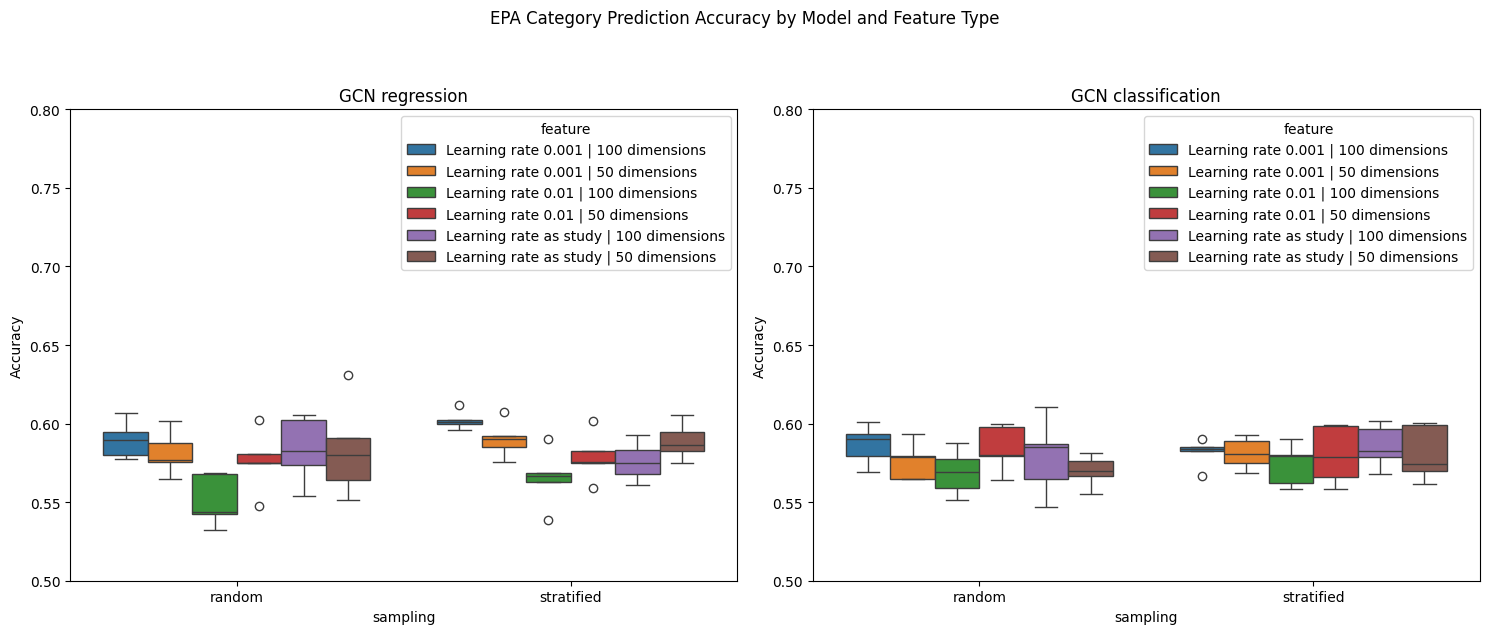

In [44]:
# Plot EPA accuracies by sampling method
plt.figure(figsize=(15, 6))

# Create subplots for random and stratified sampling
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('EPA Category Prediction Accuracy by Model and Feature Type', y=1.05)


# Random sampling
sns.boxplot(data=accuracies_df[accuracies_df['model'] == 'GCN regression'], 
            x='sampling', y='value', hue='feature', ax=axes[0])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('GCN regression')
axes[0].set_ylim(0.5, 0.8)  

# Stratified sampling
sns.boxplot(data=accuracies_df[accuracies_df['model'] == 'GCN classification'], 
            x='sampling', y='value', hue='feature', ax=axes[1])
axes[1].set_ylabel('Accuracy')
axes[1].set_title('GCN classification')
axes[1].set_ylim(0.5, 0.8)  


print("\nAverage EPA Category Accuracies:")
avg_accuracies = accuracies_df.groupby(['sampling', 'model', 'feature'])['value'].mean()
print(avg_accuracies)

plt.tight_layout()
plt.show()

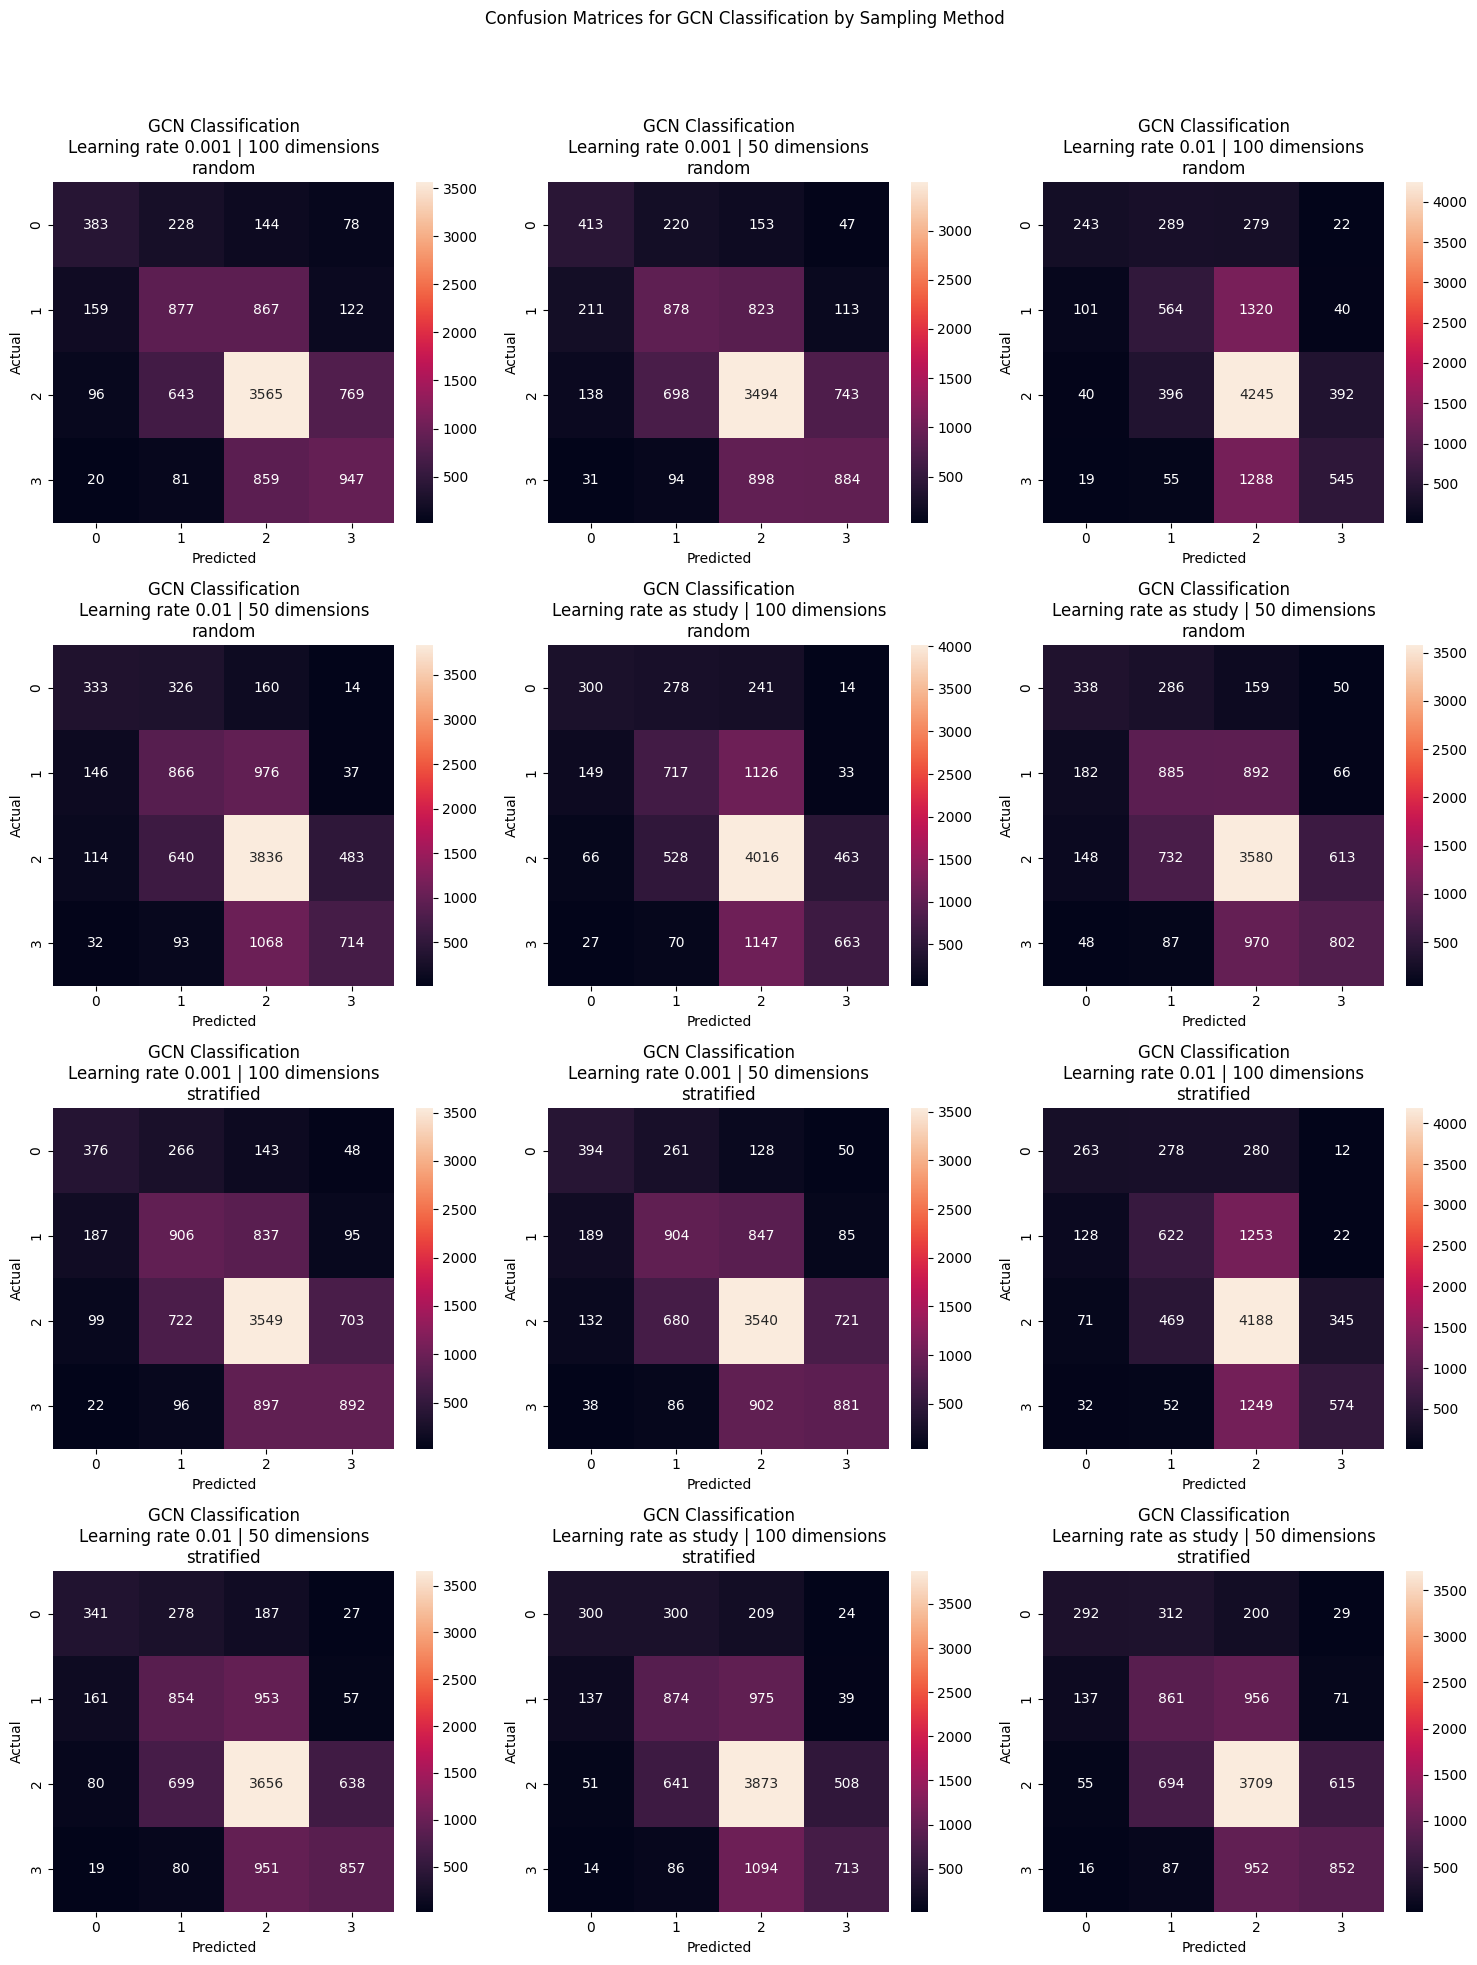

In [46]:
# Filter for GCN classification
predictions_classification = predictions[predictions['model'] == 'GCN classification']

# Unique features for GCN classification
unique_features = predictions_classification['feature'].unique()
sampling_methods = ['random', 'stratified']
model_feature_combinations = list(product(['GCN classification'], unique_features))

# Calculate the required grid size for the number of combinations
n_combinations = len(model_feature_combinations) * len(sampling_methods)
n_cols = 3
n_rows = int(np.ceil(n_combinations / n_cols))

# Create the subplots with the calculated grid size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.suptitle('Confusion Matrices for GCN Classification by Sampling Method')

# Flatten the axes array
axes = axes.flatten()

# Plot each feature-sampling combination
for idx, (sampling, (_, feature)) in enumerate(product(sampling_methods, model_feature_combinations)):
    subset = predictions_classification[(predictions_classification['feature'] == feature) &
                                        (predictions_classification['sampling'] == sampling)]
    
    ax = axes[idx]  # Select the correct subplot

    if not subset.empty:
        cm = confusion_matrix(subset['actual_epa'], subset['prediction_epa'])
        sns.heatmap(cm, annot=True, fmt='d', ax=ax)
        ax.set_title(f'GCN Classification\n{feature}\n{sampling}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
        ax.axis('off')

for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


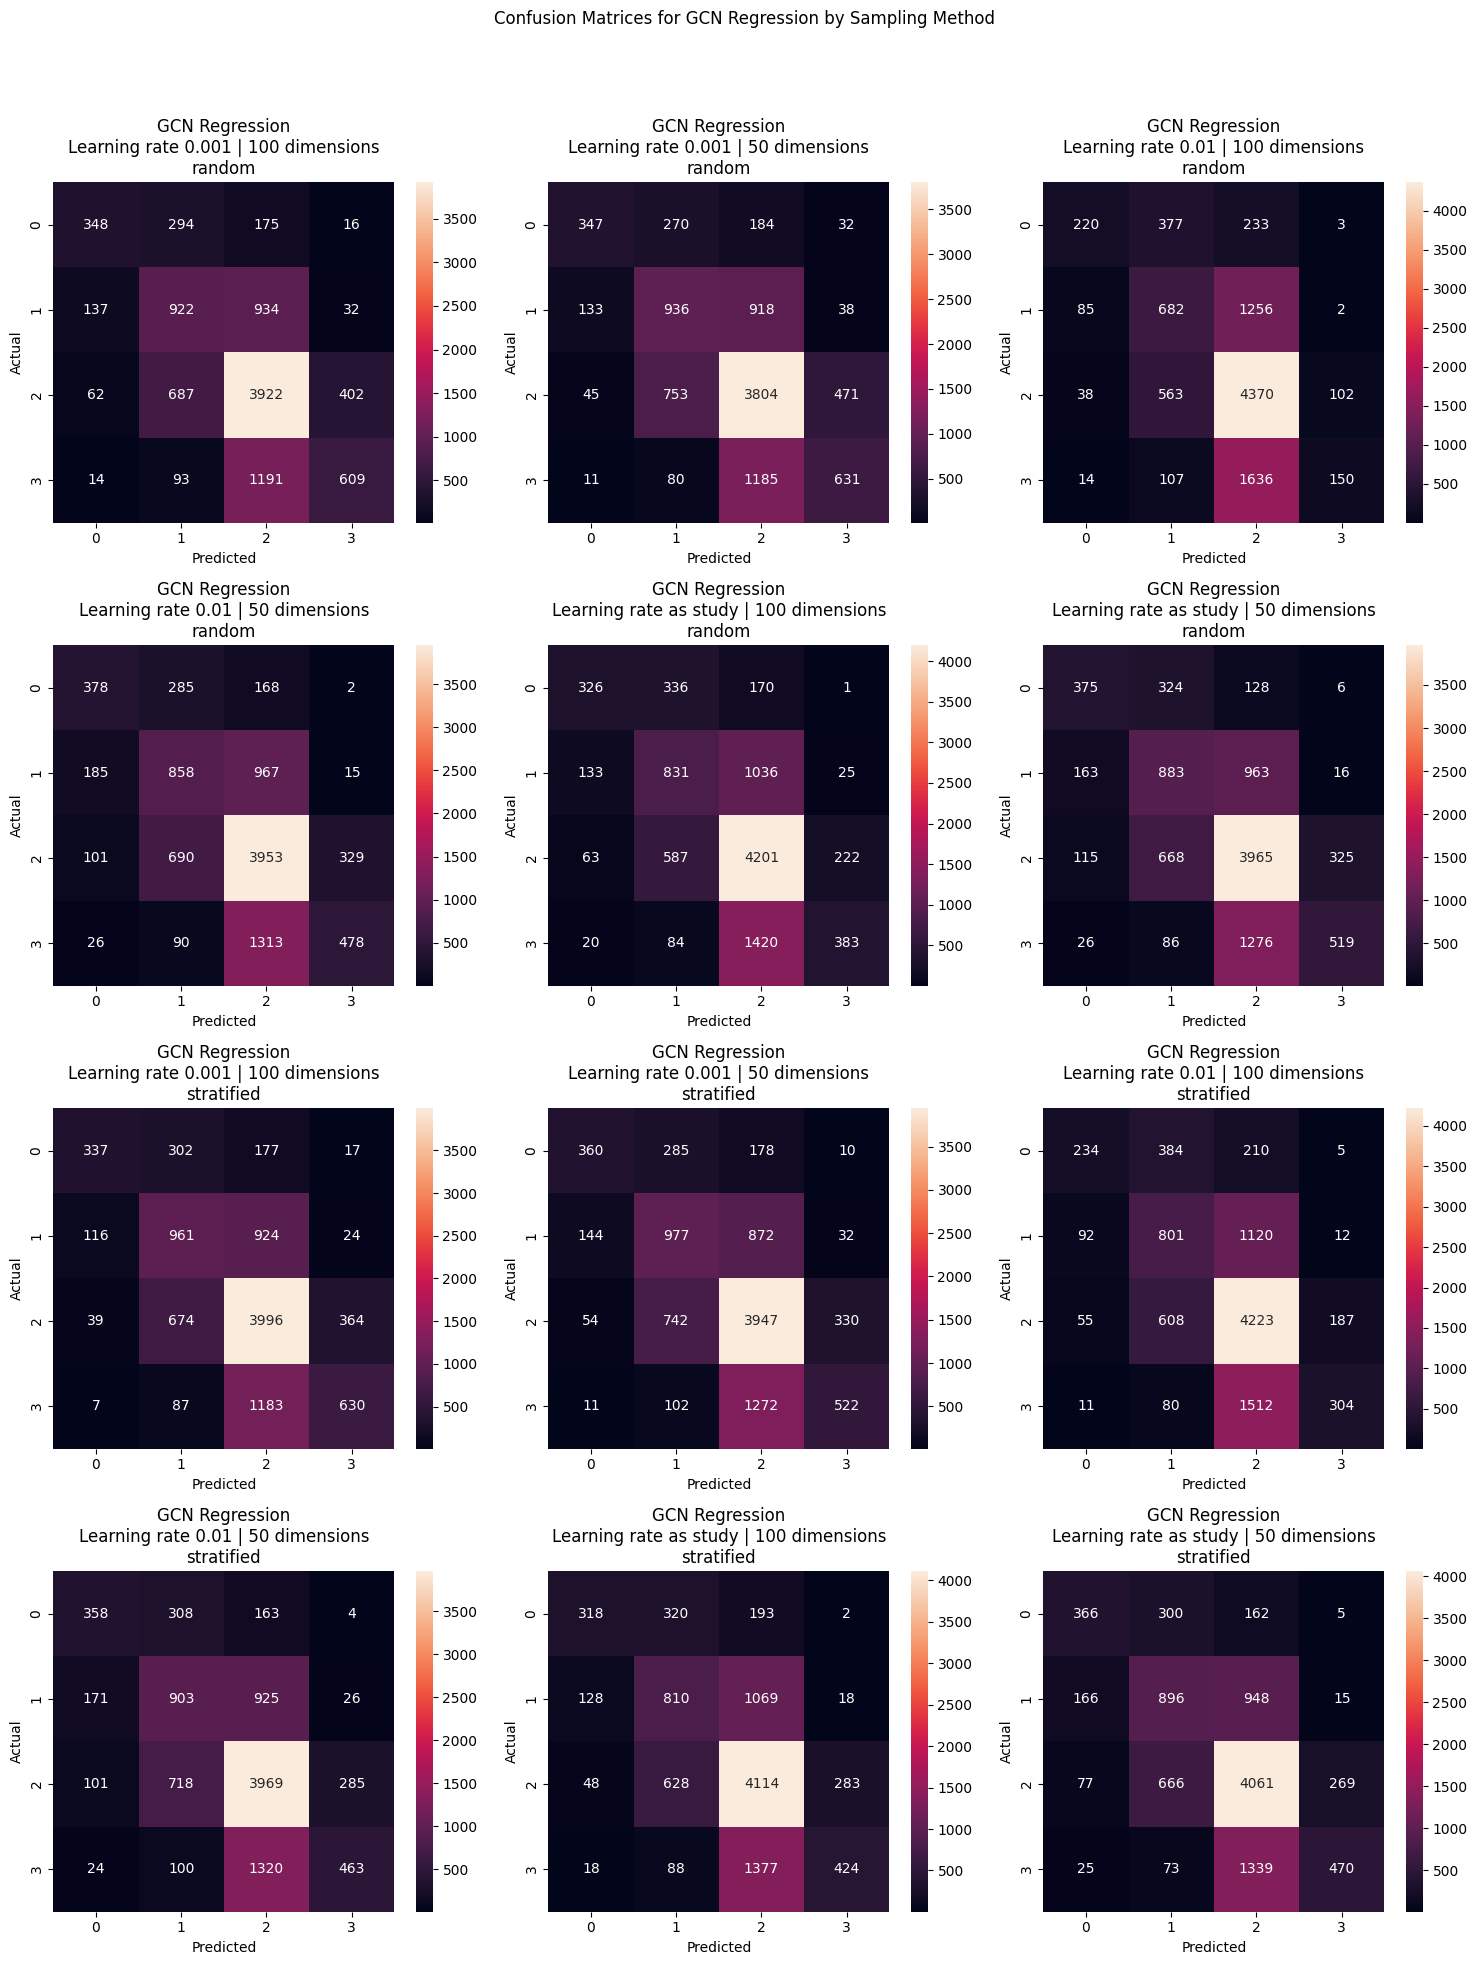

In [47]:
# Filter for GCN regression
predictions_regression = predictions[predictions['model'] == 'GCN regression']

# Unique features for GCN regression
unique_features = predictions_regression['feature'].unique()
model_feature_combinations = list(product(['GCN regression'], unique_features))

# Calculate the required grid size for the number of combinations
n_combinations = len(model_feature_combinations) * len(sampling_methods)
n_cols = 3
n_rows = int(np.ceil(n_combinations / n_cols))

# Create the subplots with the calculated grid size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.suptitle('Confusion Matrices for GCN Regression by Sampling Method')

# Flatten the axes array
axes = axes.flatten()

# Plot each feature-sampling combination
for idx, (sampling, (_, feature)) in enumerate(product(sampling_methods, model_feature_combinations)):
    subset = predictions_regression[(predictions_regression['feature'] == feature) &
                                    (predictions_regression['sampling'] == sampling)]
    
    ax = axes[idx]  # Select the correct subplot

    if not subset.empty:
        cm = confusion_matrix(subset['actual_epa'], subset['prediction_epa'])
        sns.heatmap(cm, annot=True, fmt='d', ax=ax)
        ax.set_title(f'GCN Regression\n{feature}\n{sampling}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
        ax.axis('off')

for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

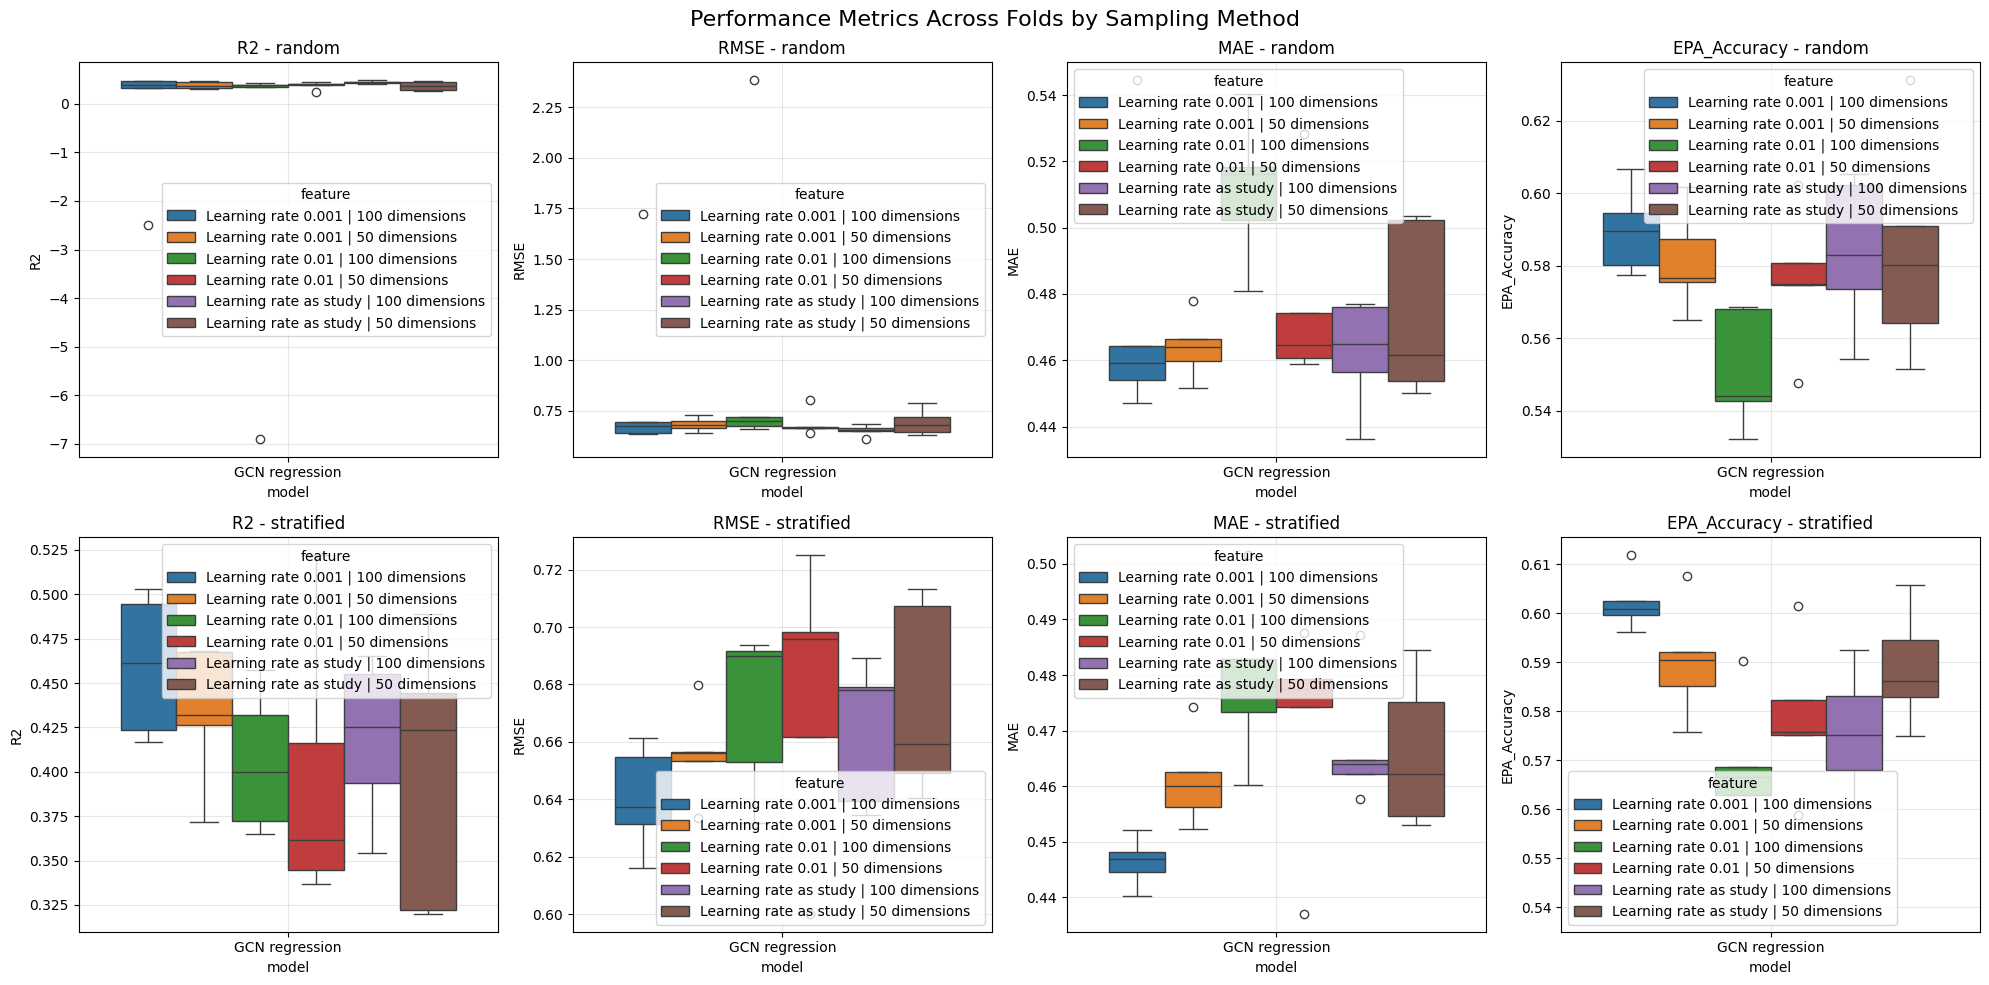


Summary Statistics:
                                                                         R2  \
                                                                       mean   
sampling   model          feature                                             
random     GCN regression Learning rate 0.001 | 100 dimensions    -0.173725   
                          Learning rate 0.001 | 50 dimensions      0.380591   
                          Learning rate 0.01 | 100 dimensions     -1.072120   
                          Learning rate 0.01 | 50 dimensions       0.375782   
                          Learning rate as study | 100 dimensions  0.437805   
                          Learning rate as study | 50 dimensions   0.366167   
stratified GCN regression Learning rate 0.001 | 100 dimensions     0.459865   
                          Learning rate 0.001 | 50 dimensions      0.433089   
                          Learning rate 0.01 | 100 dimensions      0.405275   
                          Learn

In [39]:
# 3. Calculate statistics per fold for each model/feature/sampling combination
fold_stats = []
for name, group in predictions_regression.groupby(['model', 'feature', 'fold', 'sampling']):
    model, feature, fold, sampling = name
    
    # Calculate metrics for this fold
    r2 = r2_score(group['actual_neglogld50'], group['prediction_neglogld50'])
    rmse = np.sqrt(mean_squared_error(group['actual_neglogld50'], group['prediction_neglogld50']))
    mae = mean_absolute_error(group['actual_neglogld50'], group['prediction_neglogld50'])
    epa_acc = accuracy_score(group['actual_epa'], group['prediction_epa'])
    
    fold_stats.append({
        'model': model,
        'feature': feature,
        'fold': fold,
        'sampling': sampling,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'EPA_Accuracy': epa_acc
    })

fold_stats_df = pd.DataFrame(fold_stats)

# Create box plots for each metric, separated by sampling method
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Performance Metrics Across Folds by Sampling Method', fontsize=16)

metrics = ['R2', 'RMSE', 'MAE', 'EPA_Accuracy']
for i, sampling in enumerate(['random', 'stratified']):
    for j, metric in enumerate(metrics):
        sns.boxplot(data=fold_stats_df[fold_stats_df['sampling'] == sampling], 
                   x='model', y=metric, hue='feature', ax=axes[i,j])
        axes[i,j].set_title(f'{metric} - {sampling}')
        axes[i,j].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics by sampling method
summary_stats = fold_stats_df.groupby(['sampling', 'model', 'feature']).agg({
    'R2': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'MAE': ['mean', 'std'],
    'EPA_Accuracy': ['mean', 'std']
})

print("\nSummary Statistics:")
print(summary_stats)

In [49]:
model_feature_combinations = predictions[['model', 'feature']].drop_duplicates().values.tolist()

print("\nMisclassification Analysis by Model and Sampling Method:")
for sampling in ['random', 'stratified']:
    for model, feature in model_feature_combinations:
        print(f"\n{model} - {feature}, {sampling}:")

        # Filter the subset for the current model, feature, and sampling
        subset = predictions[(predictions['model'] == model) & 
                             (predictions['feature'] == feature) &
                             (predictions['sampling'] == sampling)]
        
        # Check if there is data in the subset
        if subset.empty:
            print("  No data available for this combination.")
            continue
        
        # Calculate the confusion matrix
        cm = confusion_matrix(subset['actual_epa'], subset['prediction_epa'])
        
        # Calculate misclassification proportions for each class
        for i in range(4):  # Assuming 4 classes (0,1,2,3)
            total_in_class = cm[i].sum()
            correct = cm[i, i]
            misclassified = total_in_class - correct
            
            print(f"\n  Class {i}:")
            print(f"  Total samples: {total_in_class}")
            print(f"  Misclassified: {misclassified} ({misclassified / total_in_class * 100:.1f}%)")
            
            # Show distribution of misclassifications
            for j in range(4):  # Assuming 4 classes (0,1,2,3)
                if i != j:
                    prop = cm[i, j] / total_in_class * 100 if total_in_class > 0 else 0
                    print(f"    As {j}: {cm[i, j]} ({prop:.1f}%)")



Misclassification Analysis by Model and Sampling Method:

GCN classification - Learning rate 0.001 | 100 dimensions, random:

  Class 0:
  Total samples: 833
  Misclassified: 450 (54.0%)
    As 1: 228 (27.4%)
    As 2: 144 (17.3%)
    As 3: 78 (9.4%)

  Class 1:
  Total samples: 2025
  Misclassified: 1148 (56.7%)
    As 0: 159 (7.9%)
    As 2: 867 (42.8%)
    As 3: 122 (6.0%)

  Class 2:
  Total samples: 5073
  Misclassified: 1508 (29.7%)
    As 0: 96 (1.9%)
    As 1: 643 (12.7%)
    As 3: 769 (15.2%)

  Class 3:
  Total samples: 1907
  Misclassified: 960 (50.3%)
    As 0: 20 (1.0%)
    As 1: 81 (4.2%)
    As 2: 859 (45.0%)

GCN classification - Learning rate 0.001 | 50 dimensions, random:

  Class 0:
  Total samples: 833
  Misclassified: 420 (50.4%)
    As 1: 220 (26.4%)
    As 2: 153 (18.4%)
    As 3: 47 (5.6%)

  Class 1:
  Total samples: 2025
  Misclassified: 1147 (56.6%)
    As 0: 211 (10.4%)
    As 2: 823 (40.6%)
    As 3: 113 (5.6%)

  Class 2:
  Total samples: 5073
  Misclassi

In [50]:
# Calculate misclassification counts for each model/feature combination
for sampling in ['random', 'stratified']:
    print(f"\n=== {sampling.capitalize()} Sampling ===")
    
    for model in predictions['model'].unique():
        for feature in predictions[predictions['model'] == model]['feature'].unique():
            subset = predictions[
                (predictions['model'] == model) & 
                (predictions['feature'] == feature) &
                (predictions['sampling'] == sampling)
            ]
            
            total_samples = len(subset)
            misclassified = sum(subset['actual_epa'] != subset['prediction_epa'])
            
            print(f"\n{model} - {feature}:")
            print(f"Total samples: {total_samples}")
            print(f"Misclassified: {misclassified} ({(misclassified/total_samples*100):.2f}%)")


=== Random Sampling ===

GCN classification - Learning rate 0.001 | 100 dimensions:
Total samples: 9838
Misclassified: 4066 (41.33%)

GCN classification - Learning rate 0.001 | 50 dimensions:
Total samples: 9838
Misclassified: 4169 (42.38%)

GCN classification - Learning rate 0.01 | 100 dimensions:
Total samples: 9838
Misclassified: 4241 (43.11%)

GCN classification - Learning rate 0.01 | 50 dimensions:
Total samples: 9838
Misclassified: 4089 (41.56%)

GCN classification - Learning rate as study | 100 dimensions:
Total samples: 9838
Misclassified: 4142 (42.10%)

GCN classification - Learning rate as study | 50 dimensions:
Total samples: 9838
Misclassified: 4233 (43.03%)

GCN regression - Learning rate 0.001 | 100 dimensions:
Total samples: 9838
Misclassified: 4037 (41.03%)

GCN regression - Learning rate 0.001 | 50 dimensions:
Total samples: 9838
Misclassified: 4120 (41.88%)

GCN regression - Learning rate 0.01 | 100 dimensions:
Total samples: 9838
Misclassified: 4416 (44.89%)

GCN re

In [52]:
# Find molecules that are misclassified
misclassified = predictions[predictions['actual_epa'] != predictions['prediction_epa']]

# Count how many times each molecule (SMILES) is misclassified
misclass_counts = misclassified.groupby('smiles').size().sort_values(ascending=False)

# Save the misclassification counts to a CSV file
misclass_counts.to_csv('misclass_counts.csv')

# Show top 10 most commonly misclassified molecules
print("Top 10 most commonly misclassified molecules:")

# Slice to get the top 10 most commonly misclassified molecules
for smiles, count in misclass_counts.head(10).items():
    # Get the actual EPA category for this molecule
    actual_epa = predictions[predictions['smiles'] == smiles]['actual_epa'].iloc[0]
    
    print(f"\nMisclassified {count} times:")
    print(f"SMILES: {smiles}")
    print(f"Actual EPA category: {actual_epa}")

Top 10 most commonly misclassified molecules:

Misclassified 24 times:
SMILES: O=C1NC(CCCl)Oc2ccccc21
Actual EPA category: 3

Misclassified 24 times:
SMILES: O=P(O)(O)Oc1c(Br)cc(Br)cc1-c1cc(Br)cc(Br)c1O
Actual EPA category: 1

Misclassified 24 times:
SMILES: COc1cc2c(OC3OCC(OC)C(OC)C3O)c3c(c(-c4ccc5c(c4)OCO5)c2cc1OC)COC3=O
Actual EPA category: 0

Misclassified 24 times:
SMILES: O=S(=O)(CCl)c1ccc(Br)cc1
Actual EPA category: 3

Misclassified 24 times:
SMILES: CCNc1nc(NC(C)(C)C)nc(OC)n1
Actual EPA category: 1

Misclassified 24 times:
SMILES: CCNc1nc(Cl)nc(NCC)n1
Actual EPA category: 3

Misclassified 24 times:
SMILES: CC(=O)OCCCl
Actual EPA category: 0

Misclassified 24 times:
SMILES: CC1(C)CN(c2ccccc2)NC1=O
Actual EPA category: 0

Misclassified 24 times:
SMILES: COc1cc2c3cc1Oc1cc(ccc1O)CC1c4c(cc(OC)c(O)c4Oc4ccc(cc4)CC3N(C)CC2)CC[N+]1(C)C
Actual EPA category: 0

Misclassified 24 times:
SMILES: COc1cc2ccc(=O)oc2cc1OC
Actual EPA category: 1


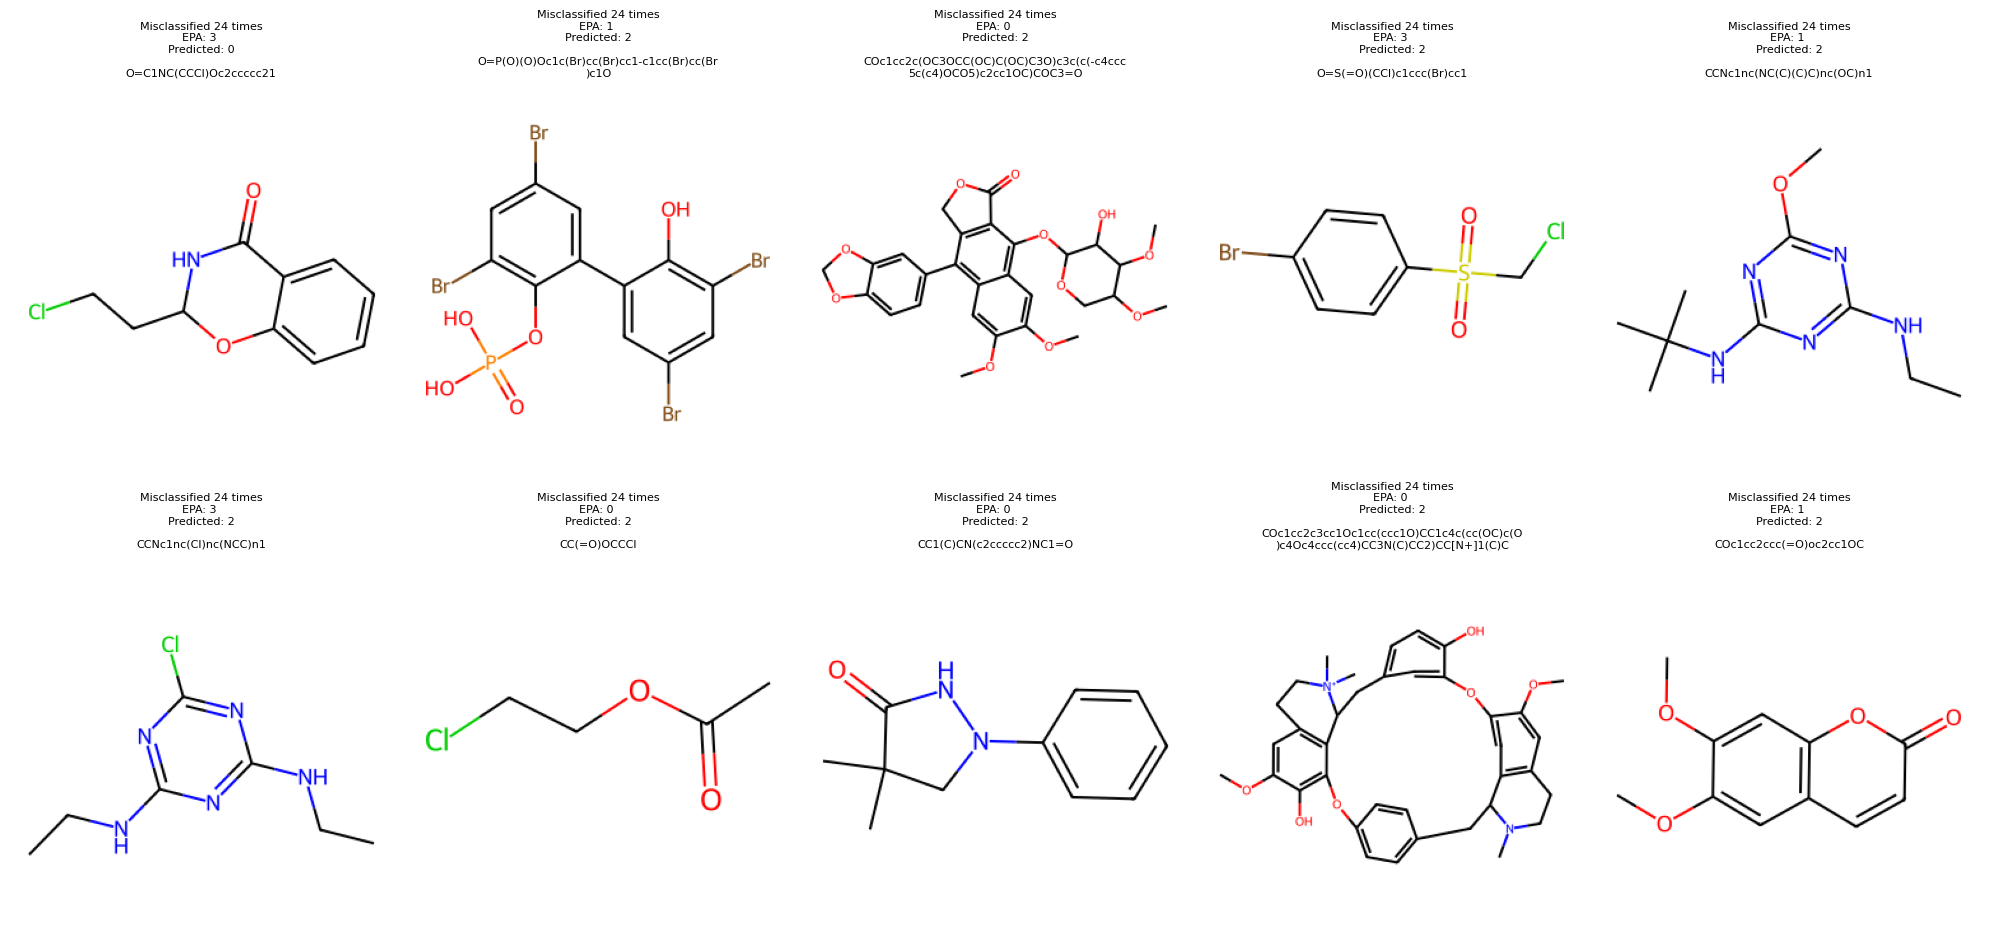

In [53]:
# Find molecules that are misclassified
misclassified = predictions[predictions['actual_epa'] != predictions['prediction_epa']]

# Count how many times each molecule (SMILES) is misclassified
misclass_counts = misclassified.groupby('smiles').size().sort_values(ascending=False)

# Get top 10 most misclassified SMILES
top_10_smiles = misclass_counts.head(10).index

# Create a figure with subplots for the molecules
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Made figure slightly taller
axes = axes.ravel()

for idx, smiles in enumerate(top_10_smiles):
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    
    # Get molecule details
    mol_details = predictions[predictions['smiles'] == smiles].iloc[0]
    
    # Plot molecule
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    # Add title and SMILES with line breaks for readability
    title = f'Misclassified {misclass_counts[smiles]} times\nEPA: {mol_details["actual_epa"]} \nPredicted: {mol_details["prediction_epa"]}'
    
    # Add SMILES string, wrapped to multiple lines if too long
    wrapped_smiles = '\n'.join([smiles[i:i+40] for i in range(0, len(smiles), 40)])
    title += f'\n\n{wrapped_smiles}'
    
    axes[idx].set_title(title, fontsize=8, wrap=True)

plt.tight_layout()
plt.show()